In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [2]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [3]:
smiles_and_names[0][0]

'COCc1c(O)c2c(c(C)c1OC1OC(CO)C(O)C(O)C1O)OC(c1ccc(OC)cc1)CC2=O'

In [4]:
smiles_and_names[0]

('COCc1c(O)c2c(c(C)c1OC1OC(CO)C(O)C(O)C1O)OC(c1ccc(OC)cc1)CC2=O',
 '5-hydroxy-6-(methoxymethyl)-2-(4-methoxyphenyl)-8-methyl-7-{[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy}-2,3-dihydro-1-benzopyran-4-one',
 506.5040000000003,
 'dataset_train_1d')

In [5]:
from inference.inference_utils import choose_model 
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [6]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model, test_loader = choose_model("optional", return_test_loader=True)

max_radius = fp_loader.max_radius




loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_1/checkpoints/epoch=95-step=21696.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [7]:
from inference.inference_utils import  get_test_loader

H_loader = get_test_loader("H-NMR", False, hparams)

In [7]:
model

OptionalInputRankedTransformer(
  (enc): SignCoordinateEncoder()
  (loss): BCEWithLogitsLoss()
  (NMR_type_embedding): Embedding(4, 784)
  (fc): Linear(in_features=784, out_features=16384, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-15): 16 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=784, out_features=784, bias=True)
        )
        (linear1): Linear(in_features=784, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=784, bias=True)
        (norm1): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [7]:
# fp_loader.setup(max_radius=6, out_dim = 16384)
# max_radius = fp_loader.max_radius
# hparams = {'out_dim': 16384}


In [8]:
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [9]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)

(526316, 526316)

In [10]:
from rdkit.Chem import rdFingerprintGenerator

def gen_mfp(smiles):
    MFP_generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    mol = Chem.MolFromSmiles(smiles)
    fp = MFP_generator.GetFingerprint(mol)
    return torch.tensor(fp).float()

In [11]:
from torch.nn.functional import cosine_similarity
import tqdm

In [30]:
total_cos = []
for idx, batch in tqdm.tqdm(enumerate(test_loader)):
    
    inputs, extra_info = batch
    (ground_smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
    # if (smiles[0]) == "COC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3":
    #     print("Found the molecule")
    #     print(idx)
    #     break
    
    inputs = inputs.to(model.device)
    NMR_type_indicator = NMR_type_indicator[0].to(model.device)
    pred = model(inputs, NMR_type_indicator)
    pred=torch.sigmoid(pred) # sigmoid
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    i=0
    for value, (retrieval_smile, name, _, _), retrieved_FP in topk:
            
        mfp_truth = gen_mfp(ground_smiles[i])
        mfp_pred = gen_mfp(retrieval_smile)
        cos_curr = cosine_similarity(mfp_truth, mfp_pred, dim=0)
        total_cos.append(cos_curr.item())
        # if retrieval_smile != ground_smiles[i]:
        #     print(f"Ground: {ground_smiles[i]}, Retrieval: {retrieval_smile}, Cosine: {cos_curr.item()}")
    # if idx == 5:
    #     break   

print(np.mean(total_cos))

0it [00:00, ?it/s]

4056it [01:08, 59.07it/s]

0.883331320099753


In [24]:
total_cos

[1.0]

In [12]:
extra_info 

[['COC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3',
  'Artemether (SM-224)',
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]),
  '/workspace/SMILES_dataset/test/oneD_NMR/10021.pt',
  ['Sesquiterpenoids']]]

############################################### compound number: 1##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.6757208704948425
Ground Truth NMR and structure


/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/dataset_utils.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


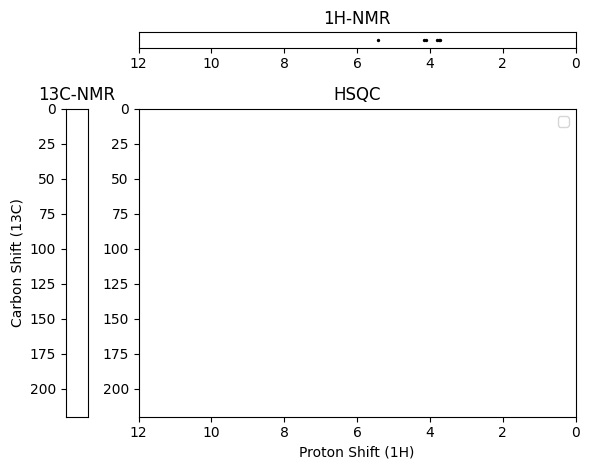

Ground truth chemical name METHYL GALACTOSIDE
Ground truth SMILES COC1OC(CO)C(O)C(O)C1O


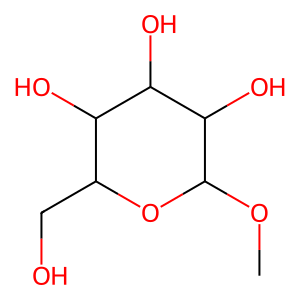

pred FP:         [[0], [5], [6], [12], [16], [30], [33], [41], [43]]
________retival #1, cosine similarity to prediction: 0.8069226145744324_________________
retrival is the same as ground truth: False
ground truth FP [[0], [2], [5], [6], [12], [15], [16], [30], [41], [43], [49], [65], [66], [73], [87], [92], [99], [101], [109], [135], [161], [176], [201], [220], [380], [4431]]
retrived FP     [[0], [2], [5], [6], [12], [16], [30], [33], [41], [43], [65], [66], [73], [87], [92], [101], [109], [135], [4148]]
SMILES: O=[As](O)(O)OC1OC(CO)C(O)C1O
Name Ribose-1-arsenate


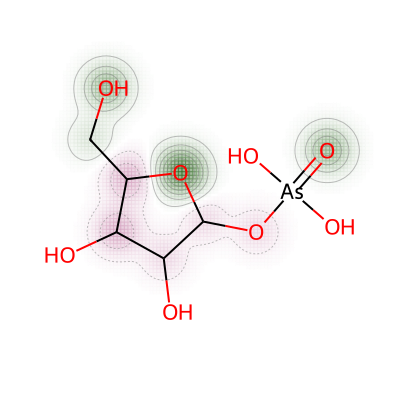

############################################### compound number: 2##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.5642048120498657
Ground Truth NMR and structure


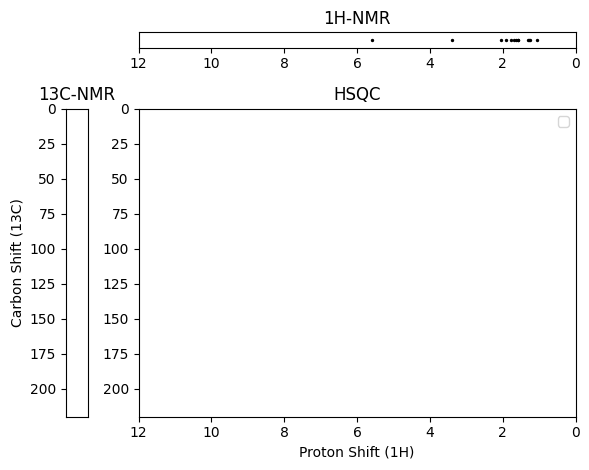

Ground truth chemical name dihydroxy-dimethoxyspongian-19-oic acid
Ground truth SMILES COC1OC(OC)C2(O)C3(C)CCC4C(C)(C(=O)O)CCCC4(C)C3CCC12O


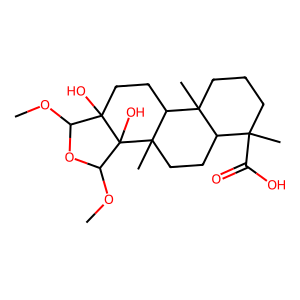

pred FP:         [[3], [4], [5], [6], [7], [10], [14], [18], [26], [29], [33], [37], [40], [49], [77]]
________retival #1, cosine similarity to prediction: 0.7580345869064331_________________
retrival is the same as ground truth: False
ground truth FP [[0], [2], [3], [4], [5], [6], [7], [10], [14], [15], [18], [26], [33], [40], [41], [45], [49], [63], [77], [89], [147], [243], [256], [380], [433], [472], [585], [827], [864], [1259], [1953], [2141], [2308], [2458], [2755], [3404], [3442], [4579], [4622], [4890], [5859], [8616], [13454], [16288]]
retrived FP     [[3], [4], [5], [6], [7], [10], [14], [18], [26], [33], [37], [40], [49], [465], [585], [1634], [2132], [16026]]
SMILES: CC1CCC(C)(C(=O)O)C1(C)C
Name "cis-(1~{R},3~{S})-1,2,2,3-tetramethylcyclopentanecarboxylic acid"


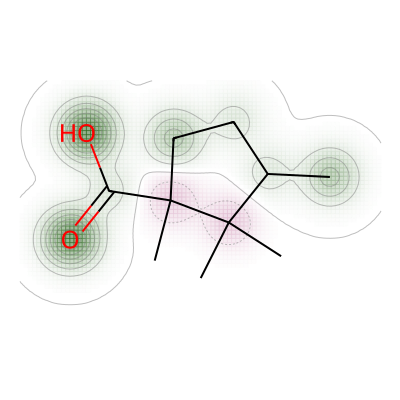

############################################### compound number: 3##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.626906156539917
Ground Truth NMR and structure


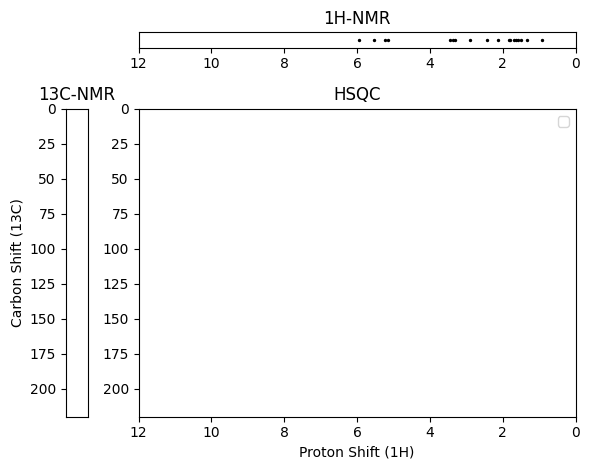

Ground truth chemical name dictyoepoxide
Ground truth SMILES COC1OC(OC)C2C1=CCC1OC1(C)CCC2C(C)CCC=C(C)C


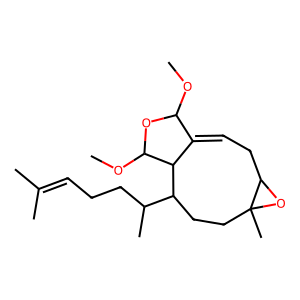

pred FP:         [[0], [3], [4], [5], [6], [7], [8], [10], [11], [12], [14], [17], [18], [19], [23], [25], [28], [29], [33], [35], [49], [79], [84], [247], [251], [307], [370], [997], [1029], [1089], [1424], [1967], [3712], [4321], [6966]]
________retival #1, cosine similarity to prediction: 0.7333791255950928_________________
retrival is the same as ground truth: False
ground truth FP [[0], [2], [4], [5], [7], [8], [10], [12], [14], [15], [17], [18], [19], [25], [26], [28], [29], [41], [49], [56], [65], [79], [116], [179], [183], [247], [307], [370], [380], [385], [537], [556], [717], [836], [844], [1654], [1767], [1967], [2324], [3712], [3841], [4431], [4640], [4789], [6379], [6442], [7309], [9629]]
retrived FP     [[0], [3], [4], [5], [6], [7], [10], [11], [12], [16], [17], [18], [19], [23], [28], [29], [33], [35], [40], [49], [55], [77], [79], [84], [199], [208], [230], [245], [247], [251], [307], [370], [427], [540], [621], [629], [717], [759], [803], [997], [1029], [1084], [1089]

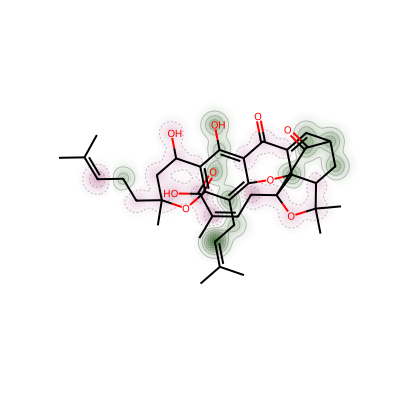

############################################### compound number: 4##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.7214759588241577
Ground Truth NMR and structure


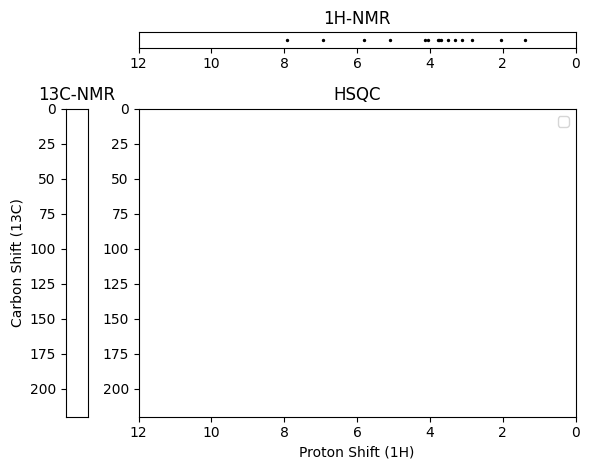

Ground truth chemical name Oxypaeonidanin
Ground truth SMILES COC1OC2(C)CC(=O)C3CC2(OC2OC(CO)C(O)C(O)C2O)C13COC(=O)c1ccc(O)cc1


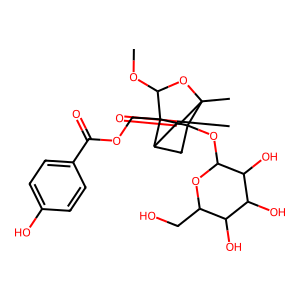

pred FP:         [[0], [1], [2], [3], [4], [5], [6], [7], [10], [12], [15], [16], [18], [19], [29], [30], [33], [41], [43], [49], [59], [65], [66], [73], [81], [87], [92], [99], [101], [109], [122], [124], [135], [161], [176], [179], [201], [220], [263], [298], [299], [300], [326], [647], [774], [1838], [4368], [5169], [7742], [7864], [7886], [10942]]
________retival #1, cosine similarity to prediction: 0.8460676670074463_________________
retrival is the same as ground truth: False
ground truth FP [[0], [1], [2], [3], [4], [5], [6], [7], [10], [11], [12], [15], [16], [18], [19], [23], [29], [30], [33], [41], [43], [47], [49], [55], [65], [66], [73], [87], [92], [93], [99], [101], [109], [122], [135], [161], [176], [179], [184], [201], [220], [249], [263], [280], [281], [298], [325], [380], [647], [649], [679], [1394], [1881], [2755], [2999], [4016], [4026], [4356], [4368], [4959], [5058], [5908], [7660], [9499], [10062], [10634], [16288]]
retrived FP     [[0], [1], [2], [3], [5], [6], 

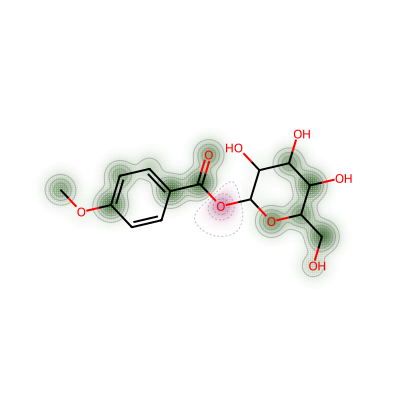

############################################### compound number: 5##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.6055468916893005
Ground Truth NMR and structure


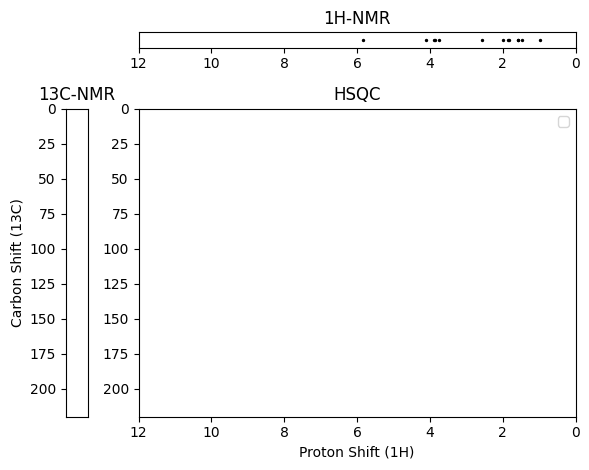

Ground truth chemical name sculponin K
Ground truth SMILES C=C1C2CC(O)C3C45CCCC(C)(CO)C4C(O)C(O)(OC5)C3(C2)C1O


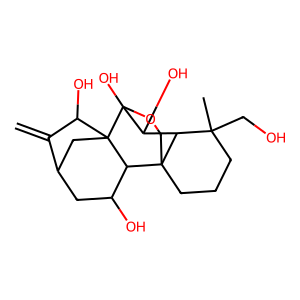

pred FP:         [[0], [4], [5], [6], [7], [10], [11], [14], [16], [18], [29], [30], [33], [49], [80], [272]]
________retival #1, cosine similarity to prediction: 0.7243179082870483_________________
retrival is the same as ground truth: False
ground truth FP [[0], [4], [5], [6], [7], [12], [16], [18], [26], [29], [30], [35], [45], [49], [55], [63], [80], [105], [272], [303], [326], [357], [436], [472], [498], [1101], [1231], [1309], [1505], [1524], [2232], [3213], [3277], [3766], [4392], [4720], [7602], [11694], [12276], [15579]]
retrived FP     [[0], [4], [5], [6], [7], [11], [14], [16], [18], [26], [29], [33], [49], [63], [76], [80], [100], [105], [272], [291], [305], [386], [393], [537], [734], [799], [850], [979], [1462], [1926], [2523], [2785], [2998], [9927]]
SMILES: C=C1CC(O)C2C(=C)C(=O)OC2C2C1CCC2(C)O
Name Vestenolide


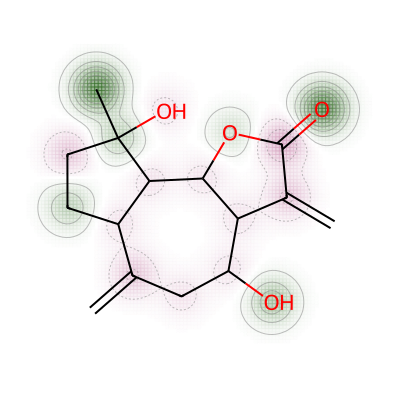

############################################### compound number: 6##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.40755701065063477
Ground Truth NMR and structure


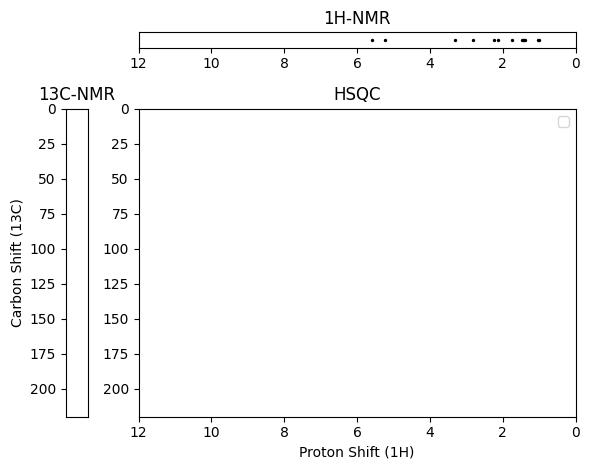

Ground truth chemical name Artemether (SM-224)
Ground truth SMILES COC1OC2OC3(C)CCC4C(C)CCC(C1C)C24OO3


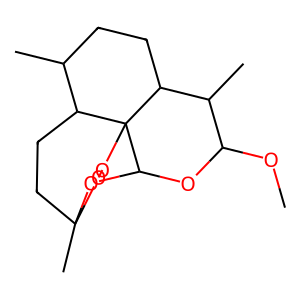

pred FP:         [[4], [5], [6], [7], [10], [11], [17], [18], [26], [29], [33], [45], [49]]
________retival #1, cosine similarity to prediction: 0.7253626585006714_________________
retrival is the same as ground truth: False
ground truth FP [[0], [2], [4], [5], [7], [14], [15], [18], [26], [37], [41], [49], [65], [106], [179], [329], [380], [411], [419], [560], [2297], [3072], [4127], [4431], [4643], [8796], [15585]]
retrived FP     [[2], [3], [4], [5], [6], [7], [8], [10], [11], [17], [18], [25], [26], [28], [29], [33], [35], [45], [49], [67], [77], [97], [206], [275], [327], [472], [549], [946], [969], [1184], [1227], [1232], [1291], [1380], [1409], [1574], [2408], [2737], [2818], [12088]]
SMILES: CC(=O)OC1CC2C(C)(C)CCCC2(C=O)C2=C1C(=O)C(C(C)C)=C(O)C2=O
Name 4a-formyl-6-hydroxy-7-isopropyl-1,1-dimethyl-5,8-dioxo-2,3,4,9,10,10a-hexahydrophenanthren-9-yl acetate


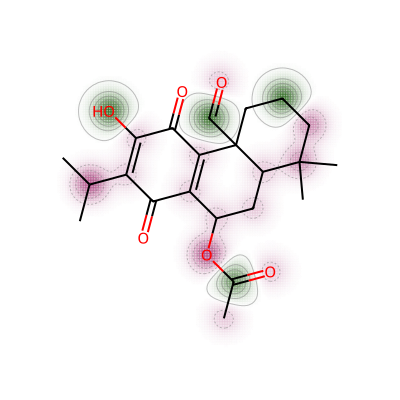

############################################### compound number: 7##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.38724708557128906
Ground Truth NMR and structure


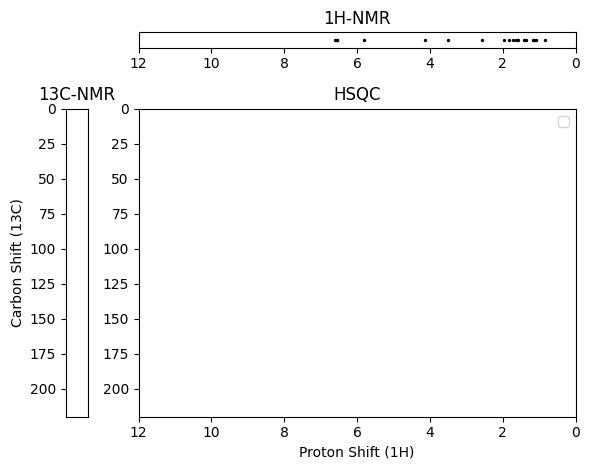

Ground truth chemical name (1S,2S,5S,14S,15R,18R,19R,20S)-20-Methoxy-5,15,19-trimethyl-6,21-dioxahexacyclo[17.3.3.0~1,18~.0~2,15~.0~5,14~.0~7,12~]pentacosa-7,9,11-trien-10-ol
Ground truth SMILES COC1OCC23CCCC1(C)C2CCC1(C)C2Cc4cc(O)ccc4OC2(C)CCC13


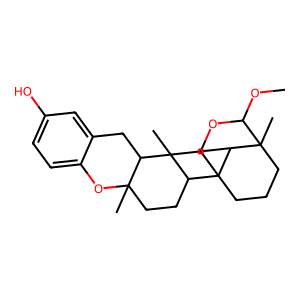

pred FP:         [[0], [4], [5], [6], [7], [11], [14], [16], [18], [19], [29], [33], [35], [37], [49], [100], [238], [394], [748]]
________retival #1, cosine similarity to prediction: 0.7060726284980774_________________
retrival is the same as ground truth: False
ground truth FP [[0], [1], [2], [4], [5], [6], [7], [9], [14], [15], [18], [19], [23], [26], [29], [45], [49], [77], [89], [93], [95], [151], [184], [193], [213], [256], [351], [371], [380], [433], [436], [438], [472], [621], [844], [864], [1101], [1767], [2714], [2755], [3766], [6558], [7249], [8712], [11692], [13672], [15666], [16288]]
retrived FP     [[0], [2], [4], [5], [6], [7], [11], [15], [16], [18], [19], [29], [33], [35], [37], [49], [63], [100], [131], [225], [228], [230], [318], [380], [394], [419], [529], [748], [2337], [3128], [10412]]
SMILES: COC1C=CC(C)(O)C=CC(=O)OC(C)C(C)CC(O)C=C1C
Name Albocycline M-7


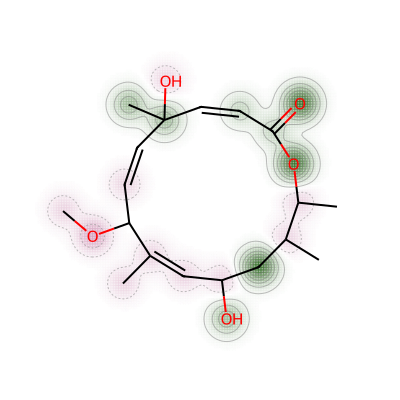

############################################### compound number: 8##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.7442207932472229
Ground Truth NMR and structure


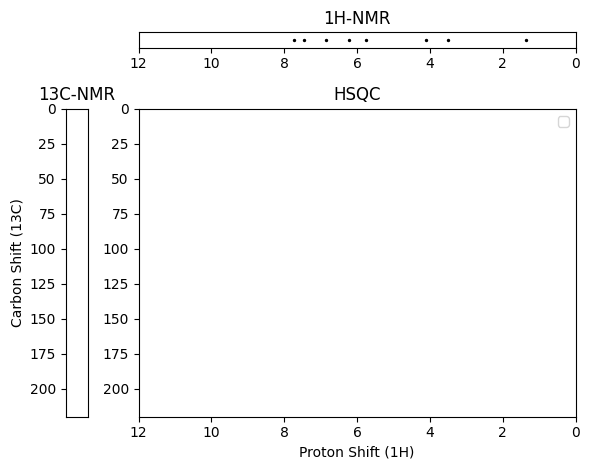

Ground truth chemical name 23733-92-8
Ground truth SMILES COC1c2c(ccc3ccc(=O)oc23)OC(C)(C)C1O


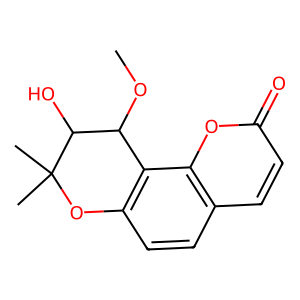

pred FP:         [[0], [1], [2], [5], [6], [7], [9], [15], [16], [18], [19], [29], [33], [39], [49], [64], [95], [130], [160], [245], [268], [303], [459], [547], [596], [621], [803], [834], [1315], [1489], [1871], [1903], [1906], [2152], [2685], [3639], [3939], [4046], [4539], [6127]]
________retival #1, cosine similarity to prediction: 0.9179210662841797_________________
retrival is the same as ground truth: False
ground truth FP [[0], [1], [2], [5], [6], [7], [15], [16], [18], [19], [29], [33], [39], [49], [64], [95], [245], [248], [268], [303], [371], [380], [459], [547], [621], [803], [1086], [1315], [1489], [1906], [3109], [4046], [4539], [4694], [6301], [6446], [12064], [15159]]
retrived FP     [[0], [1], [5], [6], [7], [9], [16], [18], [19], [29], [33], [39], [49], [64], [95], [130], [160], [268], [303], [459], [547], [618], [803], [834], [1315], [1489], [1871], [1903], [1906], [2152], [2307], [2685], [3639], [3939], [4539], [6127]]
SMILES: CC1(C)Oc2cc3oc(=O)ccc3cc2C(O)C1O
Name 

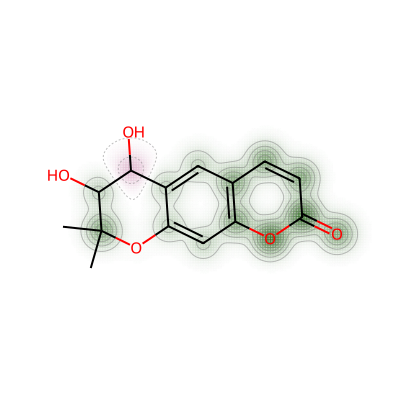

############################################### compound number: 9##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.8759221434593201
Ground Truth NMR and structure


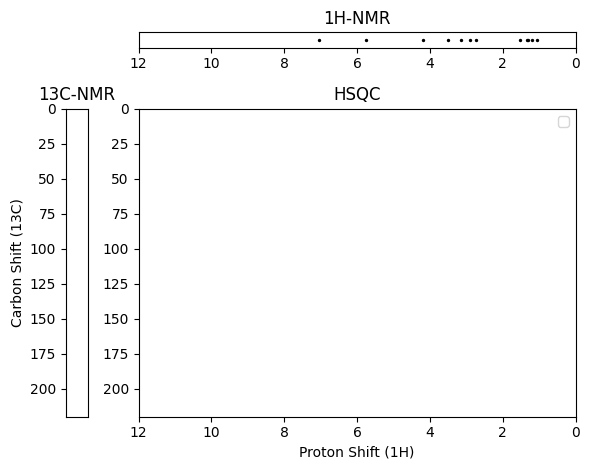

Ground truth chemical name Taxodistine A
Ground truth SMILES COC1c2cc(C(C)C)c(O)c(O)c2C2(C)CCCC(C)(C)C2C1O


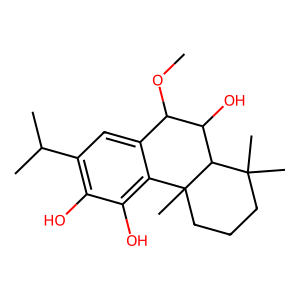

pred FP:         [[0], [4], [5], [6], [7], [8], [9], [16], [18], [19], [23], [25], [26], [29], [33], [43], [45], [49], [84], [160], [326], [472], [549], [793], [924], [969], [1805], [2951], [3211], [3836], [4521]]
________retival #1, cosine similarity to prediction: 0.9238227605819702_________________
retrival is the same as ground truth: False
ground truth FP [[2], [4], [5], [6], [7], [8], [9], [15], [16], [18], [19], [23], [25], [26], [29], [43], [45], [49], [84], [160], [326], [380], [472], [549], [793], [924], [969], [1976], [3211], [3836], [4046], [4521], [9012]]
retrived FP     [[0], [4], [5], [6], [7], [8], [9], [11], [16], [18], [19], [23], [25], [26], [29], [33], [43], [45], [49], [84], [100], [160], [326], [472], [549], [623], [793], [924], [969], [1805], [2951], [3211], [3836], [4521], [9905]]
SMILES: CC(C)c1cc2c(c(O)c1O)C13CCCC(C)(C)C1C(O)C2OC3=O
Name Isorosmanol


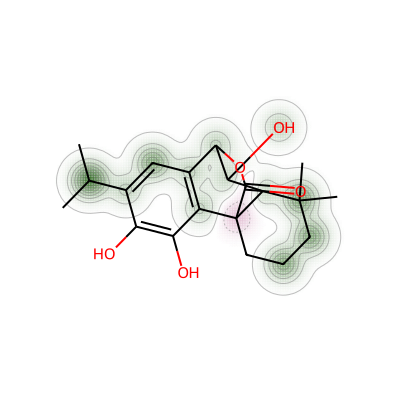

############################################### compound number: 10##############################################################
Ground truth cosine similarity to prediction(floating point number after sigmoid):  0.33077937364578247
Ground Truth NMR and structure


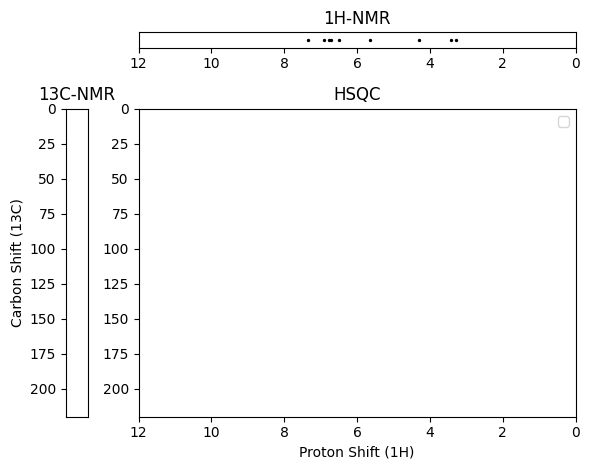

Ground truth chemical name 3'-Deoxy-O-Methylsappanol
Ground truth SMILES COC1c2ccc(O)cc2OCC1(O)Cc1ccc(O)cc1


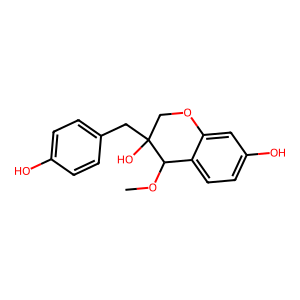

pred FP:         [[0], [1], [2], [3], [5], [6], [9], [10], [12], [16], [19], [23], [29], [33], [40], [41], [43], [44], [47], [65], [66], [87], [92], [93], [99], [101], [113], [161], [184], [255], [280], [281], [284], [395], [414], [481], [492], [545], [561], [686], [796], [1047], [1093], [1135], [1304], [1329], [1373], [1411], [1430], [3146], [3776], [4556], [6063], [6092], [6685], [6945], [7671], [7696], [8201], [8872], [13125]]
________retival #1, cosine similarity to prediction: 0.8451049327850342_________________
retrival is the same as ground truth: False
ground truth FP [[0], [1], [2], [4], [5], [6], [7], [9], [12], [15], [19], [23], [29], [48], [49], [63], [93], [95], [143], [160], [184], [280], [281], [321], [380], [436], [438], [687], [753], [1445], [1501], [2451], [3733], [4286], [6748], [7476], [8220], [16347]]
retrived FP     [[0], [1], [2], [3], [5], [6], [9], [10], [12], [16], [19], [23], [29], [33], [39], [40], [41], [43], [44], [47], [57], [64], [65], [66], [87], [92], 

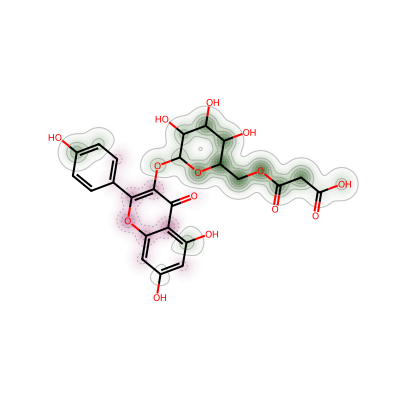

DONE






In [20]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

ignore_MW  = True
from datasets.dataset_utils import  plot_NMR
from inference.inference_utils import show_retrieved_mol_with_highlighted_frags

# model.to("cuda")
# for  which_compound in  random.sample(range(len(loader_all_inputs.dataset)), k=1):# range(0, 1):  
for which_compound in range(10):    
    
    # for idx, batch in enumerate(test_loader):
    for idx, batch in enumerate(H_loader):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path, superclasses) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        # batch[0] = batch[0].to("cuda")
        hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        if ignore_MW:
            inputs = inputs[:, :-1]
            NMR_type_indicator = NMR_type_indicator[0][:-1].to(model.device)
        else:
            NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    ground_truth_FP = fp_loader.build_mfp_for_new_SMILES(smiles[0])
    cos_ground_and_pred = compute_cos_sim(ground_truth_FP, pred.squeeze().float().to(ground_truth_FP.device))
    if cos_ground_and_pred < 1:
        print(f"############################################### compound number: {which_compound+1}##############################################################")
        print("Ground truth cosine similarity to prediction(floating point number after sigmoid): ", cos_ground_and_pred)
        # print(inputs)
        
        print("Ground Truth NMR and structure")
        plot_NMR(hsqc, c_tensor, h_tensor)
        

        # # ground truth
        mol = Chem.MolFromSmiles(smiles[0])
        # mol = Chem.AddHs(mol)
        print(f"Ground truth chemical name {names[0]}")
        print(f"Ground truth SMILES {smiles[0]}")
        # print(f"Ground truth NMR path {path[0]}")
        img = Draw.MolToImage(mol, size=(300, 300))
        img.show()
        
        print(f"pred FP:        ", pred_FP.nonzero().tolist())
        
        topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
        i=0
        for value, (smile, name, _, _), retrieved_FP in topk:
            print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
            print(f"retrival is the same as ground truth: {smile == smiles[0]}")
            print("ground truth FP", ground_truth_FP.nonzero().tolist())
            # print("retrived FP", retrieved_FP.nonzero().tolist())
            print("retrived FP    ", retrieved_FP.to_dense().squeeze().nonzero().tolist())
            mol = Chem.MolFromSmiles(smile)

            print(f"SMILES: {smile}") 
            print(f"Name {name}")
            # img = Draw.MolToImage(mol)
            # img.show()
            img = show_retrieved_mol_with_highlighted_frags(pred_FP, smile)
            img.show()
            i+=1
        
print("DONE\n\n\n\n")
        



In [22]:
h_tensor

tensor([3.4200000763, 4.3099999428, 5.6500000954, 6.5100002289, 6.7699999809,
        7.3499999046, 3.2899999619, 6.9200000763, 6.7100000381])

In [14]:
inputs.shape, NMR_type_indicator.shape

(torch.Size([1, 10, 3]), torch.Size([10]))

In [15]:
NMR_type_indicator

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 3], device='cuda:0')

In [11]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [40]:
def draw_mol_from_dir(dir):
    """
    Draw the molecule from the directory
    """
    smiles_file = Path(dir) / "SMILES.txt"
    with open(smiles_file, "r") as f:
        smiles = f.read().strip()
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    display(img)
    
    return smiles, img

In [12]:
# look for the higher cos_sim possible in our dataset
from inference.inference_utils import show_retrieved_mol_with_highlighted_frags
def retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"retival #{i+1}, cosine similarity between retrieval and ground truth: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        # img = Draw.MolToImage(mol)
        img = show_retrieved_mol_with_highlighted_frags(groud_truth_FP[0], smile)
        img.show()
        
        # display(img)
        i+=1

In [13]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = fp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)


# Kavaratamide_A_bit_infos = count_circular_substructures(Kavaratamide_A_SMILES)

In [14]:
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = fp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


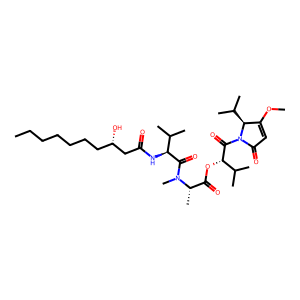

In [15]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img

retival #1, cosine similarity between retrieval and ground truth: 0.7378648519515991_____________________________
retrived FP [0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.0, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12909944355487823, 0.12909944355487823, 0.0, 0.0,

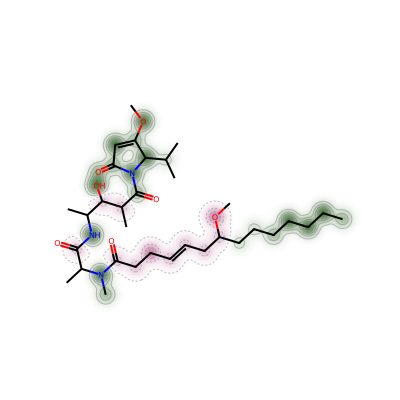

retival #2, cosine similarity between retrieval and ground truth: 0.6067880988121033_____________________________
retrived FP [0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.1714985966682434, 0.0, 0.0, 0.1714985966682434, 0.0, 0.1714985966682434, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1714985966682434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

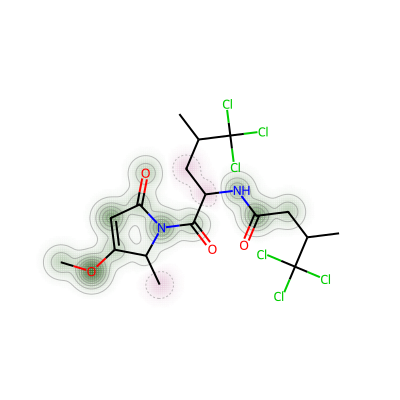

In [16]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7202965617179871



________retival #1, cosine similarity to prediction: 0.6675078868865967_________________
________retival's   cosine similarity to ground truth:  0.7378647923469543
________retival #1, cosine similarity to prediction: 0.6675078868865967_________________
________retival's   cosine similarity to ground truth:  0.7378647923469543
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name 934248-75-6


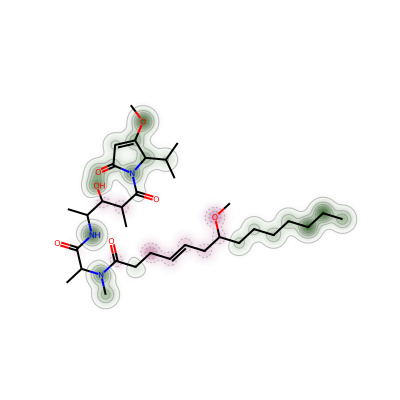

________retival #2, cosine similarity to prediction: 0.6392946243286133_________________
________retival's   cosine similarity to ground truth:  0.5570029616355896
________retival #2, cosine similarity to prediction: 0.6392946243286133_________________
________retival's   cosine similarity to ground truth:  0.5570029616355896
SMILES: CCCCCCC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)OC(C)=O
Name 139291778


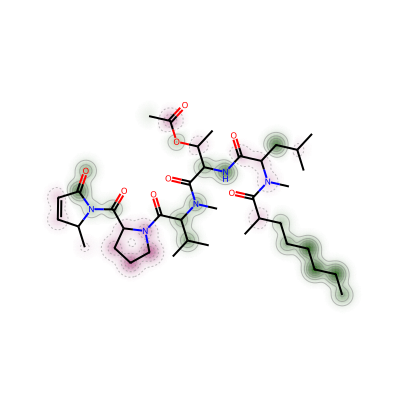

________retival #3, cosine similarity to prediction: 0.6229509115219116_________________
________retival's   cosine similarity to ground truth:  0.5227084755897522
________retival #3, cosine similarity to prediction: 0.6229509115219116_________________
________retival's   cosine similarity to ground truth:  0.5227084755897522
SMILES: CCCCC(C)CC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CC(O)CC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)O
Name 139291944


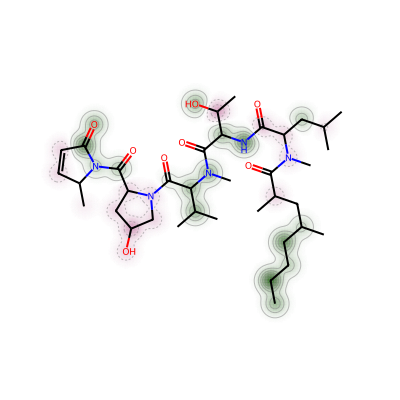

(['CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC',
  'CCCCCCC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CCCC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)OC(C)=O',
  'CCCCC(C)CC(C)C(=O)N(C)C(CC(C)C)C(=O)NC(C(=O)N(C)C(C(=O)N1CC(O)CC1C(=O)N1C(=O)C=CC1C)C(C)C)C(C)O'],
 ['934248-75-6', '139291778', '139291944'])

In [20]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "DB_Specific_Radius", filter_by_MW="from_input",
                #    weight_pred = torch.tensor(-fp_loader.total_entropy_of_all_bits).to("cuda").float()
                )
                   

In [21]:
def investigate_new_molecule(compound_dir, SMILES):
    return
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['All-NMR']:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model_DB_specific_FP(model_type)
        max_radius = fp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [22]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)

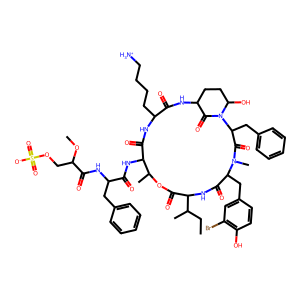

Error in O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O
Expecting value: line 1 column 1 (char 0)


(['unknown'], None)

In [23]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
Draw.MolToImage(Chem.MolFromSmiles(newCompoundA_SMILES)).show()
get_superclass_and_glycoside(newCompoundA_SMILES)

In [24]:
newCompoundA_FP = fp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

retival #1, cosine similarity between retrieval and ground truth: 0.8002593517303467_____________________________
retrived FP [0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.0, 0.0, 0.08638684451580048, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.0, 0.0, 0.08638684451580048, 0.08638684451580048, 0.0, 0.08638684451580048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086386844515800

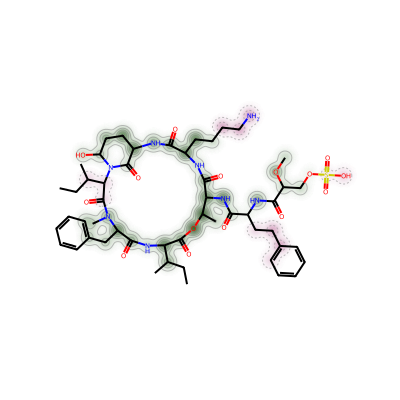

retival #2, cosine similarity between retrieval and ground truth: 0.7915244102478027_____________________________
retrived FP [0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.0, 0.0, 0.08391813933849335, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.0, 0.0, 0.08391813933849335, 0.08391813933849335, 0.0, 0.08391813933849335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

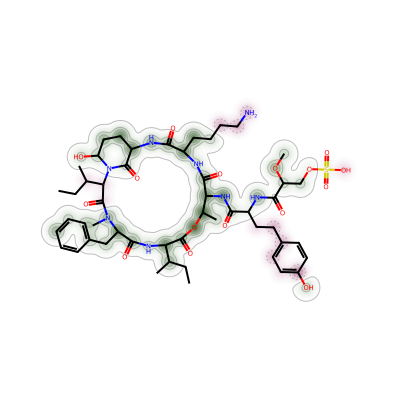

In [25]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.703415036201477



________retival #1, cosine similarity to prediction: 0.8597201108932495_________________
________retival's   cosine similarity to ground truth:  0.7357916235923767
________retival #1, cosine similarity to prediction: 0.8597201108932495_________________
________retival's   cosine similarity to ground truth:  0.7357916235923767
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 49766272


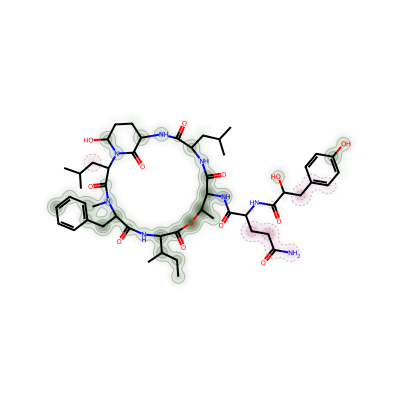

________retival #2, cosine similarity to prediction: 0.8520301580429077_________________
________retival's   cosine similarity to ground truth:  0.7395751476287842
________retival #2, cosine similarity to prediction: 0.8520301580429077_________________
________retival's   cosine similarity to ground truth:  0.7395751476287842
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(O)COP(=O)(O)O)C(C)OC1=O
Name "[(2~{S})-3-[[(2~{S},5~{S},8~{S},11~{R},12~{S},15~{S},18~{R},21~{R})-2,15-dibenzyl-21-hydroxy-5-[(4-hydroxyphenyl)methyl]-4,11-dimethyl-8-[(1~{S})-1-methylpropyl]-3,6,9,13,16,22-hexaoxo-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-2-hydroxy-3-oxo-propyl] dihydrogen phosphate"


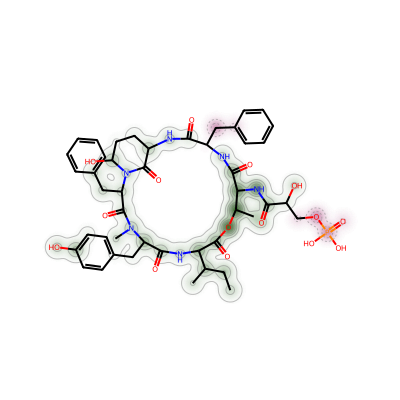

________retival #3, cosine similarity to prediction: 0.8417550325393677_________________
________retival's   cosine similarity to ground truth:  0.7302383184432983
________retival #3, cosine similarity to prediction: 0.8417550325393677_________________
________retival's   cosine similarity to ground truth:  0.7302383184432983
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC2C=CC(O)CC2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 102041486


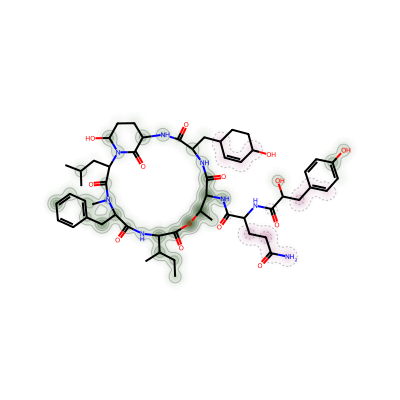

(['CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(O)COP(=O)(O)O)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(CC(C)C)N2C(=O)C(CCC2O)NC(=O)C(CC2C=CC(O)CC2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O'],
 ['49766272',
  '"[(2~{S})-3-[[(2~{S},5~{S},8~{S},11~{R},12~{S},15~{S},18~{R},21~{R})-2,15-dibenzyl-21-hydroxy-5-[(4-hydroxyphenyl)methyl]-4,11-dimethyl-8-[(1~{S})-1-methylpropyl]-3,6,9,13,16,22-hexaoxo-10-oxa-1,4,7,14,17-pentazabicyclo[16.3.1]docosan-12-yl]amino]-2-hydroxy-3-oxo-propyl] dihydrogen phosphate"',
  '102041486'])

In [26]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_A"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=True, include_hsqc=False,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundA_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")

In [27]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_A"
investigate_new_molecule(compound_dir, newCompoundA_SMILES)




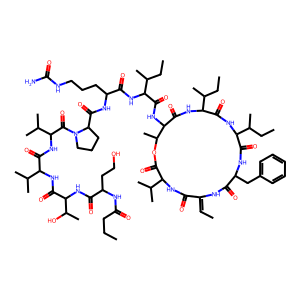

(['Oligopeptides'], False)

In [28]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()
get_superclass_and_glycoside(new_compoundB_smiles)

retival #1, cosine similarity between retrieval and ground truth: 0.9006819128990173_____________________________
retrived FP [0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356735, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.0, 0.0, 0.08164965361356735, 0.08164965361356735, 0.0, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08164965361356

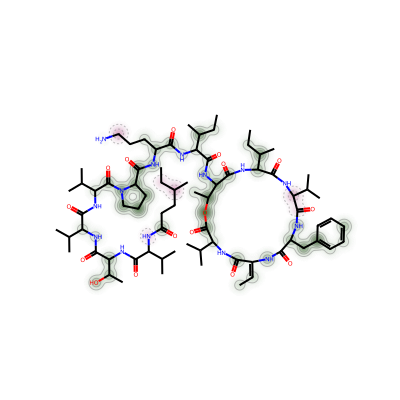

In [29]:
newCompoundB_FP = fp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)
retrieve_based_on_groudth(newCompoundB_FP.unsqueeze(dim=0).to("cuda"), k=1)




new_compound_B1


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7403514385223389



________retival #1, cosine similarity to prediction: 0.8279820680618286_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
________retival #1, cosine similarity to prediction: 0.8279820680618286_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-

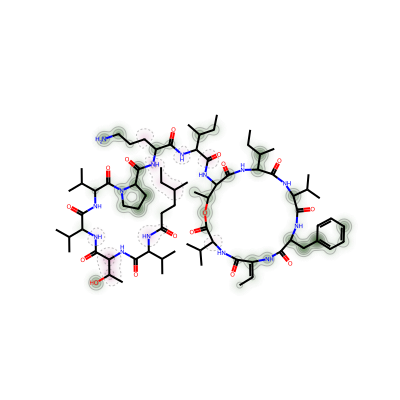

________retival #2, cosine similarity to prediction: 0.8236978054046631_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
________retival #2, cosine similarity to prediction: 0.8236978054046631_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


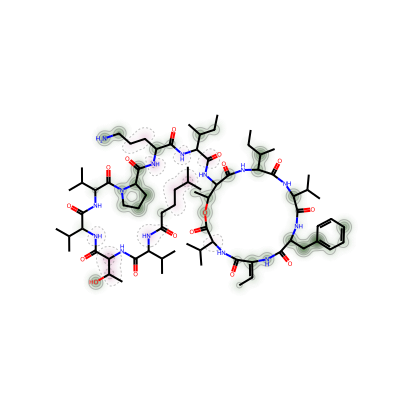

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"',
  '9898671'])

In [30]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B1"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")




new_compound_B2


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.8439829349517822



________retival #1, cosine similarity to prediction: 0.9219180345535278_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
________retival #1, cosine similarity to prediction: 0.9219180345535278_________________
________retival's   cosine similarity to ground truth:  0.8976945877075195
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 9898671


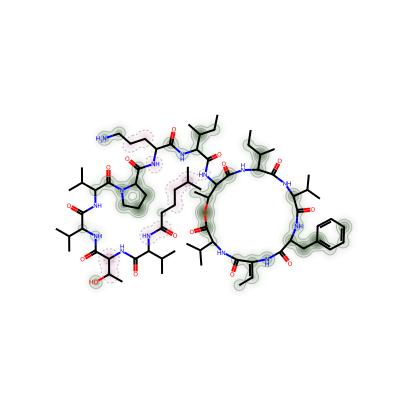

________retival #2, cosine similarity to prediction: 0.9206297397613525_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
________retival #2, cosine similarity to prediction: 0.9206297397613525_________________
________retival's   cosine similarity to ground truth:  0.9006820321083069
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-but

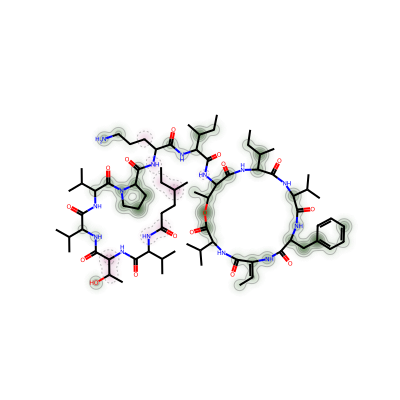

________retival #3, cosine similarity to prediction: 0.9089523553848267_________________
________retival's   cosine similarity to ground truth:  0.8860357403755188
________retival #3, cosine similarity to prediction: 0.9089523553848267_________________
________retival's   cosine similarity to ground truth:  0.8860357403755188
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name 5-OHKF


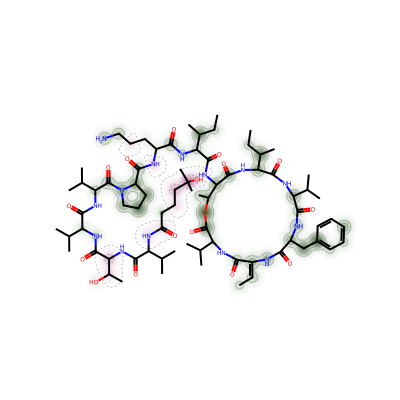

(['CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)(C)O)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['9898671',
  '"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methy

In [31]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B2"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")

In [32]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)

In [33]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)

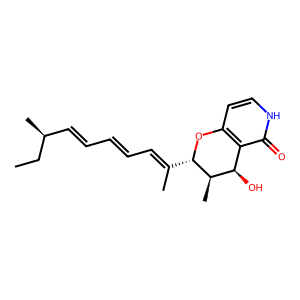




Aculeapyridone A


_________________________________________________________
Prediction's cosine similarity to ground truth:  0.7674214243888855



________retival #1, cosine similarity to prediction: 0.995710015296936_________________
________retival's   cosine similarity to ground truth:  0.7674214243888855
________retival #1, cosine similarity to prediction: 0.995710015296936_________________
________retival's   cosine similarity to ground truth:  0.7674214243888855
SMILES: CCC(C)C=CC=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C
Name YCM1008A


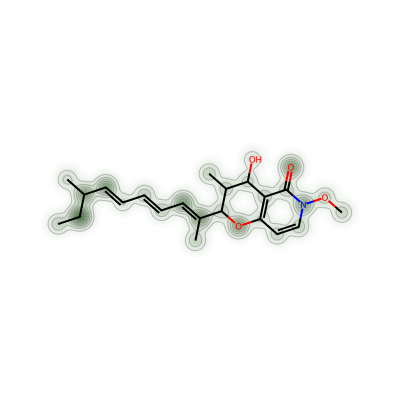

________retival #2, cosine similarity to prediction: 0.7871065735816956_________________
________retival's   cosine similarity to ground truth:  0.6463597416877747
________retival #2, cosine similarity to prediction: 0.7871065735816956_________________
________retival's   cosine similarity to ground truth:  0.6463597416877747
SMILES: CCC(C=C(C)C=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C)CO
Name "4-hydroxy-2-[7-(hydroxymethyl)-1,5-dimethyl-nona-1,3,5-trienyl]-6-methoxy-3-methyl-3,4-dihydro-2~{H}-pyrano[3,2-c]pyridin-5-one"


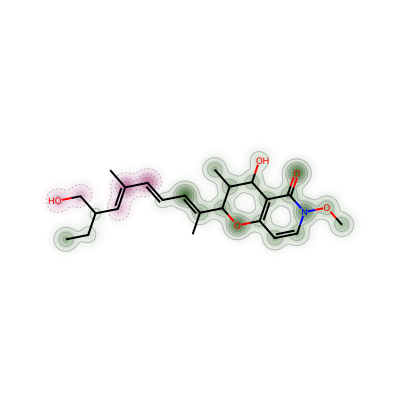

________retival #3, cosine similarity to prediction: 0.5787956118583679_________________
________retival's   cosine similarity to ground truth:  0.4776651859283447
________retival #3, cosine similarity to prediction: 0.5787956118583679_________________
________retival's   cosine similarity to ground truth:  0.4776651859283447
SMILES: CCC1Oc2ccn(OC)c(=O)c2C2C(C)CC(C)C(O)C12C
Name "(6~{S},6~{a}~{S},7~{S},8~{R},10~{S},10~{a}~{R})-6-ethyl-7-hydroxy-2-methoxy-6~{a},8,10-trimethyl-6,7,8,9,10,10~{a}-hexahydroisochromeno[4,3-c]pyridin-1-one"


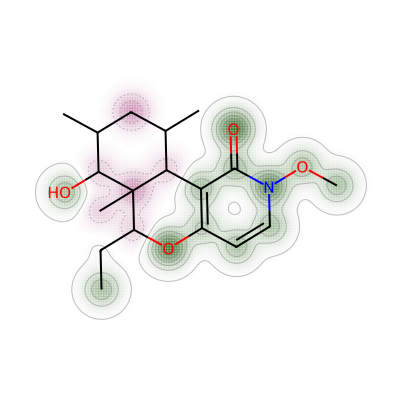

(['CCC(C)C=CC=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C',
  'CCC(C=C(C)C=CC=C(C)C1Oc2ccn(OC)c(=O)c2C(O)C1C)CO',
  'CCC1Oc2ccn(OC)c(=O)c2C2C(C)CC(C)C(O)C12C'],
 ['YCM1008A',
  '"4-hydroxy-2-[7-(hydroxymethyl)-1,5-dimethyl-nona-1,3,5-trienyl]-6-methoxy-3-methyl-3,4-dihydro-2~{H}-pyrano[3,2-c]pyridin-5-one"',
  '"(6~{S},6~{a}~{S},7~{S},8~{R},10~{S},10~{a}~{R})-6-ethyl-7-hydroxy-2-methoxy-6~{a},8,10-trimethyl-6,7,8,9,10,10~{a}-hexahydroisochromeno[4,3-c]pyridin-1-one"'])

In [47]:
compound_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/testing_compounds/Aculeapyridone A"

smiles, img = draw_mol_from_dir(compound_dir)

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP = fp_loader.build_mfp_for_new_SMILES(smiles), filter_by_MW="from_input",
                   fp_type = "DB_Specific_Radius")